# Carregar dados
* [download](https://storage.googleapis.com/tensorflow/tf-keras-datasets/minist.npz)
* Mova o arquivo "mnist.npz" para a pasta do projeto
* execute a celula abaixo

obs: é possível carregar o dataset direto pelo keras da seguinte forma:

`tf.keras.datasets.mnist.load_data(path="mnist.npz")`
    
Contudo para evitarmos complicações em lidar com o proxy da Bosch, iremos realizar o download manual do dataset.

In [1]:
import numpy as np
with np.load("mnist.npz", allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
print(f"{x_train.shape[0]} imagens de treino com resolução {x_train.shape[1]}x{x_train.shape[2]}")
print(f"shape: {x_train.shape}")

60000 imagens de treino com resolução 28x28
shape: (60000, 28, 28)


#### Visualização

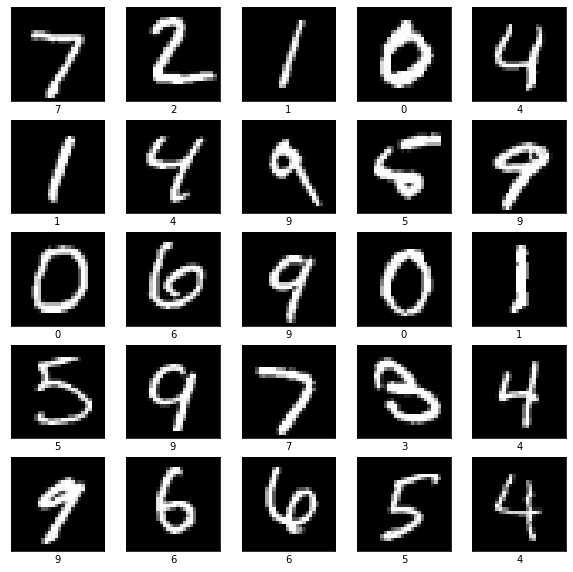

In [2]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.xlabel(str(y_test[i]))
plt.show()


### Pré-processamento

Para pré-processamento das imagens iremos normalizar os valores das imagens entre 0 e 1.
Outro fator relevante é que nosso dataset são imagens em tons de cinza, possuindo dimensões HW. Para padronizar as condições geralmente utilizadas com o keras precisamos incluir mais uma dimensão indicando a quantidade de canais: HWC = (28, 28, 1)

In [3]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train[..., np.newaxis]  # np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = x_test[..., np.newaxis]

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### Criação do modelo
Para a criação do modelos iremos utilizar um modelo não sequencial com o propósito de facilitar a visualização de qual parte da rede é o encoder e qual parte será o decoder.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

input_img = keras.Input(shape=(28, 28, 1))
    
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Callback para acompanhar as imagens geradas pelo nosso autoencoder durante o treinamento
Como vimos em aulas passadas o Callback padrão do Keras salva apenas as métricas de treinamento, nesse caso queremos também observar a imagem gerada pelo autoencoder com o decorrer do treinamento

In [5]:
import io
import os

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback


In [6]:
class OutputViewer(Callback):
    def __init__(self, images, log_dir="./"):
        super().__init__()
        self._log_dir = log_dir
        self._file_writer = tf.summary.create_file_writer(os.path.join(log_dir, "images"))
        self._images = images


    @staticmethod
    def _plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def _image_grid(self):
        """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
        # Create a figure to contain the plot.
        figure = plt.figure(figsize=(10, 10))
        pred = self.model.predict(self._images)
        for i in range(25):
            # Start next subplot.
            plt.subplot(5, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(pred[i], cmap=plt.cm.gray)

        return figure

    def on_epoch_end(self, epoch, logs=None):
        # Prepare the plot
        figure = self._image_grid()
        # Convert to image and log
        with self._file_writer.as_default():
            tf.summary.image("Generated data", OutputViewer._plot_to_image(figure), step=epoch)

In [7]:
output_viewer_callback = OutputViewer(x_test[:25], log_dir='./autoencoder4')
# tensorboard --logdir=./autoencoder3 --samples_per_plugin images=1000

### Treinamento

In [8]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=200,
                steps_per_epoch=10,
                batch_size=128,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='./autoencoder4'), output_viewer_callback])

Epoch 1/200
10/10 [==============================] - 2s 132ms/step - loss: 0.6940
Epoch 2/200
10/10 [==============================] - 1s 123ms/step - loss: 0.6430
Epoch 3/200
10/10 [==============================] - 1s 129ms/step - loss: 0.4994
Epoch 4/200
10/10 [==============================] - 1s 131ms/step - loss: 0.4632
Epoch 5/200
10/10 [==============================] - 1s 105ms/step - loss: 0.4274
Epoch 6/200
10/10 [==============================] - 1s 105ms/step - loss: 0.3877
Epoch 7/200
10/10 [==============================] - 1s 111ms/step - loss: 0.3308
Epoch 8/200
10/10 [==============================] - 1s 114ms/step - loss: 0.2809
Epoch 9/200
10/10 [==============================] - 1s 118ms/step - loss: 0.2507
Epoch 10/200
10/10 [==============================] - 1s 110ms/step - loss: 0.2398
Epoch 11/200
10/10 [==============================] - 1s 109ms/step - loss: 0.2253
Epoch 12/200
10/10 [==============================] - 1s 109ms/step - loss: 0.2209
Epoch 13/200


10/10 [==============================] - 1s 113ms/step - loss: 0.1279
Epoch 100/200
10/10 [==============================] - 1s 108ms/step - loss: 0.1264
Epoch 101/200
10/10 [==============================] - 1s 110ms/step - loss: 0.1285
Epoch 102/200
10/10 [==============================] - 1s 118ms/step - loss: 0.1258
Epoch 103/200
10/10 [==============================] - 1s 119ms/step - loss: 0.1270
Epoch 104/200
10/10 [==============================] - 1s 119ms/step - loss: 0.1253
Epoch 105/200
10/10 [==============================] - 1s 130ms/step - loss: 0.1254
Epoch 106/200
10/10 [==============================] - 1s 126ms/step - loss: 0.1269
Epoch 107/200
10/10 [==============================] - 1s 108ms/step - loss: 0.1263
Epoch 108/200
10/10 [==============================] - 1s 119ms/step - loss: 0.1252
Epoch 109/200
10/10 [==============================] - 1s 119ms/step - loss: 0.1241
Epoch 110/200
10/10 [==============================] - 1s 115ms/step - loss: 0.1247
Epoch 

10/10 [==============================] - 1s 117ms/step - loss: 0.1146
Epoch 197/200
10/10 [==============================] - 1s 122ms/step - loss: 0.1162
Epoch 198/200
10/10 [==============================] - 1s 120ms/step - loss: 0.1125
Epoch 199/200
10/10 [==============================] - 2s 156ms/step - loss: 0.1148
Epoch 200/200
10/10 [==============================] - 2s 152ms/step - loss: 0.1148


### Visualização dos resultados

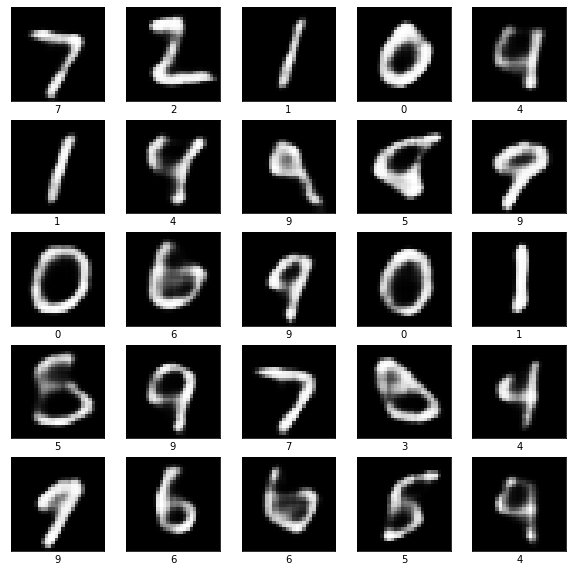

In [9]:
decoded_imgs = autoencoder.predict(x_test)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(decoded_imgs[i], cmap=plt.cm.gray)
    plt.xlabel(str(y_test[i]))
plt.show()

# Parte 2

Nessa segunda parte iremos adcionar ruídos em nossas amostras e criaremos um autoencoder capaz de identificar e remover o ruído.

### Adição de ruído aos dados de treinamento

(60000, 28, 28, 1) (60000, 28, 28, 1)


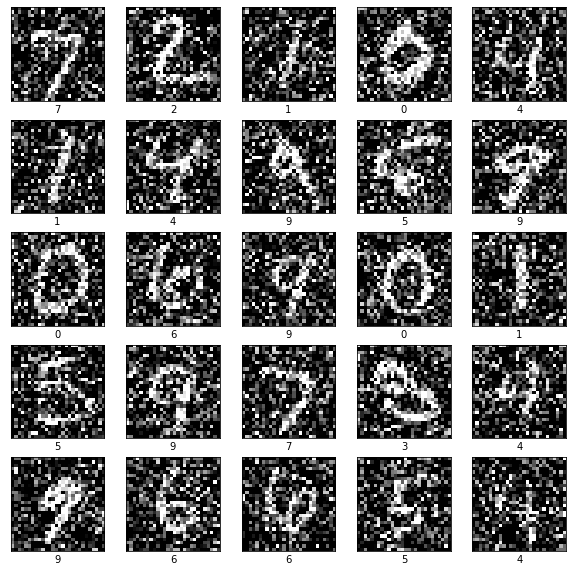

In [10]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape, x_train.shape)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_noisy[i], cmap=plt.cm.gray)
    plt.xlabel(str(y_test[i]))
plt.show()

## Criação de novo modelo para treino

Podemos até utilizar o modelo previamente treinado, mas para garantirmos um modelo sem viés iremos criar um do zero.

In [11]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='./autoencoder_noisy')])

Epoch 1/10
469/469 [==============================] - 66s 140ms/step - loss: 0.3174 - val_loss: 0.1929
Epoch 2/10
469/469 [==============================] - 62s 132ms/step - loss: 0.1829 - val_loss: 0.1647
Epoch 3/10
469/469 [==============================] - 64s 136ms/step - loss: 0.1631 - val_loss: 0.1556
Epoch 4/10
469/469 [==============================] - 65s 139ms/step - loss: 0.1545 - val_loss: 0.1489
Epoch 5/10
469/469 [==============================] - 64s 136ms/step - loss: 0.1490 - val_loss: 0.1447
Epoch 6/10
469/469 [==============================] - 67s 143ms/step - loss: 0.1450 - val_loss: 0.1408
Epoch 7/10
469/469 [==============================] - 70s 148ms/step - loss: 0.1408 - val_loss: 0.1378
Epoch 8/10
469/469 [==============================] - 69s 146ms/step - loss: 0.1377 - val_loss: 0.1346
Epoch 9/10
469/469 [==============================] - 71s 152ms/step - loss: 0.1354 - val_loss: 0.1328A: 2s - lo - ETA: 1s - loss:  - ETA: 0s - loss: 0.1
Epoch 10/10
469/469 [=

### Visualização da remoção de ruídos pelo autoencoder

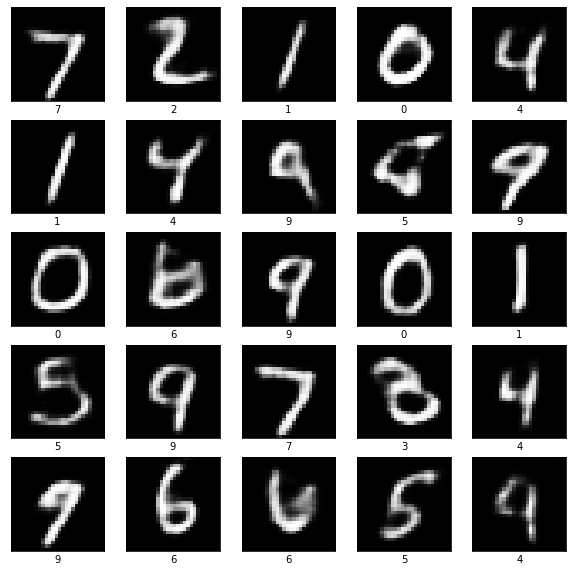

In [13]:
decoded_imgs = autoencoder.predict(x_test)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(decoded_imgs[i], cmap=plt.cm.gray)
    plt.xlabel(str(y_test[i]))
plt.show()